## CS441: Applied ML - HW 3

# Part 1: CLIP: Contrastive Language-Image Pretraining
Include all the code for Part 1 in this section

### 1.1 Prepare data

[Here](https://drive.google.com/file/d/1zJ1KfymSfsbmD6QS-F0eUC8T1PkqW0_j/view?usp=sharing) is the json file you need for labels of flowers 102

In [ ]:
import json
import os
import os.path as osp
import numpy as np
from google.colab import drive
import torch
from torchvision.datasets import Flowers102
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
drive.mount('/content/drive')
#datadir = "/content/drive/My Drive/CS441/hw3/"
datadir = "."

Mounted at /content/drive


In [ ]:
def load_flower_data(img_transform=None):
    if os.path.isdir(datadir+ "flowers-102"):
      do_download = False
    else:
      do_download = True
    train_set = Flowers102(root=datadir, split='train', transform=img_transform, download=do_download)
    test_set = Flowers102(root=datadir, split='val', transform=img_transform, download=do_download)
    classes = json.load(open(osp.join(datadir, "flowers102_classes.json")))

    return train_set, test_set, classes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# READ ME!  This takes some time (a few minutes), so if you are using Colabs, 
#           first set to use GPU: Edit->Notebook Settings->Hardware Accelerator=GPU, and restart instance

# Data structure details
#   flower_train[n][0] is the nth train image
#   flower_train[n][1] is the nth train label
#   flower_test[n][0] is the nth test image
#   flower_test[n][1] is the nth test label
#   flower_classes[k] is the name of the kth class
flower_train, flower_test, flower_classes = load_flower_data()

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

In [ ]:
len(flower_train), len(flower_test)

(1020, 1020)

Label: pink primrose


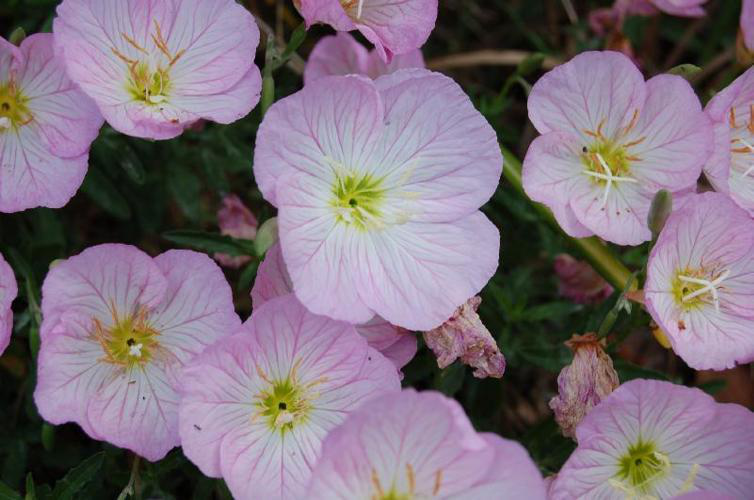

In [ ]:
# Display a sample in Flowers 102 dataset
sample_idx = 0 # Choose an image index that you want to display
print("Label:", flower_classes[flower_train[sample_idx][1]])
flower_train[sample_idx][0]

### 1.2 Prepare CLIP model

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jnlpvvzm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jnlpvvzm
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 7.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=746ddaa53068e3de41d56ec4aebda6c09a3738c80ea18a32a7f49b306602ed4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-628wsese/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [ ]:
import clip

In [ ]:
# Sets device to "cuda" if a GPU is available
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)
# If this takes a really long time, stop and then restart the download
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

cuda


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 285MiB/s]


### 1.3 CLIP zero-shot prediction

Ground truth: giant white arum lily

Top predictions:

giant white arum lily: 60.01%
           lotus: 12.98%
      siam tulip: 8.25%
       anthurium: 3.55%
   morning glory: 1.87%


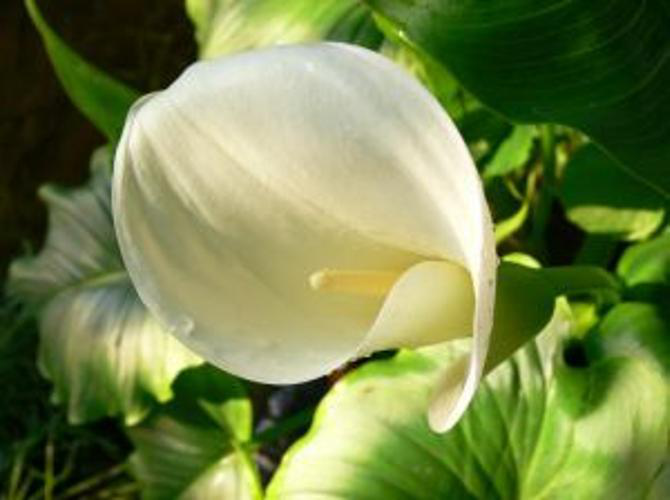

In [ ]:
"""The following is an example of using CLIP pre-trained model for zero-shot prediction task"""
# Prepare the inputs
n = 200
image, class_id = flower_train[n]
image_input = clip_preprocess(image).unsqueeze(0).to(device) # extract image and put in device memory
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}, a type of flower.") for c in flower_classes]).to(device) # put text to match to image in device memory

# Calculate features
with torch.no_grad():
    image_features = clip_model.encode_image(image_input) # compute image features with CLIP model
    text_features = clip_model.encode_text(text_inputs) # compute text features with CLIP model
image_features /= image_features.norm(dim=-1, keepdim=True) # unit-normalize image features
text_features /= text_features.norm(dim=-1, keepdim=True) # unit-normalize text features

# Pick the top 5 most similar labels for the image
similarity = (100.0 * image_features @ text_features.T) # score is cosine similarity times 100
p_class_given_image= similarity.softmax(dim=-1)  # P(y|x) is score through softmax
values, indices = p_class_given_image[0].topk(5) # gets the top 5 labels

# Print the probability of the top five labels
print("Ground truth:", flower_classes[class_id])
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{flower_classes[index]:>16s}: {100 * value.item():.2f}%")
image

### 1.4 YOUR TASK: Test CLIP zero-shot performance on Flowers 102

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader

In [ ]:
# Load flowers dataset again. This time, with clip_preprocess as transform
flower_train_trans, flower_test_trans, flower_classes = load_flower_data(img_transform=clip_preprocess)

In [ ]:
def clip_zero_shot(data_set, classes):
    data_loader = DataLoader(data_set, batch_size=64, shuffle=False)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Compute image features
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # Compute text features
            text_inputs = torch.cat([clip.tokenize(f"An image of a {c}, a type of flower.") for c in classes]).to(device)
            text_features = clip_model.encode_text(text_inputs)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Compute similarity between images and labels
            similarity = (100.0 * image_features @ text_features.T)
            predicted_labels = torch.argmax(similarity, dim=-1)

            # Compute accuracy
            correct += (predicted_labels == labels).sum().item()
            total += len(labels)

    accuracy = correct / total * 100
    return accuracy


In [ ]:
accuracy = clip_zero_shot(data_set=flower_test_trans, classes=flower_classes)
print(f"\nAccuracy = {accuracy:.3f}%")

100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Accuracy = 67.157%


### 1.5 YOUR TASK: Test CLIP linear probe performance on Flowers 102

In [ ]:
from sklearn.linear_model import LogisticRegression
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def get_features(data_set):
    # Extract image features using the CLIP model
    features = []
    labels = []
    for i in range(len(data_set)):
        img, label = data_set[i]
        with torch.no_grad():
            image = preprocess(img).unsqueeze(0).to(device)
            feature = model.encode_image(image).squeeze(0).cpu().numpy()
        features.append(feature)
        labels.append(label)

    return np.array(features), np.array(labels)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Calculate the image features
train_features, train_labels = get_features(flower_train)
test_features, test_labels = get_features(flower_test)

# Train the logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
accuracy = clf.score(test_features, test_labels)
print(f"\nAccuracy = {100*accuracy:.3f}%")



Accuracy = 93.824%


### 1.6 YOUR TASK: Evaluate a nearest-neighbor classifier on CLIP features

In [ ]:
from scipy import stats

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats


def knn(x_train, y_train, x_test, y_test, K=3):
    neigh = KNeighborsClassifier(n_neighbors=K)
    neigh.fit(x_train, y_train)
    y_pred = neigh.predict(x_test)
    accuracy = np.sum(y_pred == y_test) / len(y_test)

    return accuracy





In [ ]:
accuracy = knn(train_features, train_labels, test_features, test_labels, K=1)
print(f"\nAccuracy = {100*accuracy:.3f}%")

accuracy = knn(train_features, train_labels, test_features, test_labels, K=3)
print(f"\nAccuracy = {100*accuracy:.3f}%")

accuracy = knn(train_features, train_labels, test_features, test_labels, K=5)
print(f"\nAccuracy = {100*accuracy:.3f}%")

accuracy = knn(train_features, train_labels, test_features, test_labels, K=11)
print(f"\nAccuracy = {100*accuracy:.3f}%")

accuracy = knn(train_features, train_labels, test_features, test_labels, K=21)
print(f"\nAccuracy = {100*accuracy:.3f}%")



Accuracy = 84.118%

Accuracy = 83.235%

Accuracy = 84.412%

Accuracy = 85.294%

Accuracy = 79.706%


# Part 2: Fine-Tune for Pets Image Classification
Include all the code for Part 2 in this section

## 2.1 Prepare Data

In [1]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lrs
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from pathlib import Path
import numpy as np

In [2]:
# Mount and define data dir
from google.colab import drive
drive.mount('/content/drive')
datadir = "/content/" 
save_dir = "/content/drive/My Drive/CS441/hw3" 

Mounted at /content/drive


In [3]:
def load_pet_dataset(train_transform = None, test_transform = None):
    OxfordIIITPet = datasets.OxfordIIITPet
    if os.path.isdir(datadir+ "oxford-iiit-pet"):
      do_download = False
    else:
      do_download = True
    training_set = OxfordIIITPet(root = datadir, 
                             split = 'trainval',
                             transform = train_transform, 
                             download = do_download)

    test_set = OxfordIIITPet(root = datadir,
                           split = 'test',
                           transform = test_transform, 
                           download = do_download)   
    return training_set, test_set
  

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting /content/oxford-iiit-pet/images.tar.gz to /content/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting /content/oxford-iiit-pet/annotations.tar.gz to /content/oxford-iiit-pet
Label: Abyssinian


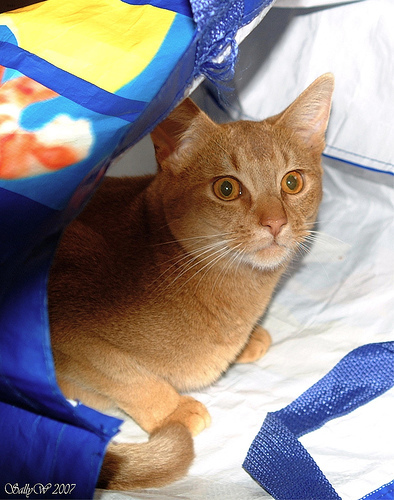

In [4]:
train_set, test_set = load_pet_dataset()

# Display a sample in OxfordIIIPet dataset
sample_idx = 0 # Choose an image index that you want to display
print("Label:", train_set.classes[train_set[sample_idx][1]])
train_set[sample_idx][0]

## 2.2 Data Preprocess

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
# Feel free to add augmentation choices 

# Apply data augmentation
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

test_transform = transforms.Compose([  
            transforms.Resize(224),  # resize to 224x224 because that's the size of ImageNet images
            transforms.CenterCrop(224), 
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

In [7]:
# Feel free to change 
train_set, test_set = load_pet_dataset(train_transform, test_transform)
train_loader = DataLoader(dataset=train_set,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_set,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)


## 2.3 Helper Functions



In [8]:
# Display the number of parameters and model structure
def display_model(model):
  # Check number of parameters 
  summary_dict = {}
  num_params = 0
  summary_str = ['='*80]

  for module_name, module in model.named_children():
      summary_count = 0
      for name, param in module.named_parameters():
          if(param.requires_grad):
              summary_count += param.numel()
              num_params += param.numel()
      summary_dict[module_name] = [summary_count]
      summary_str+= [f'- {module_name: <40} : {str(summary_count):^34s}']

  summary_dict['total'] = [num_params]

  # print summary string
  summary_str += ['='*80]
  summary_str += ['--' +  f'{"Total":<40} : {str(num_params) + " params":^34s}' +'--']
  print('\n'.join(summary_str))

  # print model structure
  print(model)

In [9]:
# Plot loss or accuracy
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Training Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

## 2.4 YOUR TASK: Fine-Tune Pre-trained Network on Pets
Read and understand the code and then uncomment it.  Then, set up your learning rate, learning scheduler, and train/evaluate. Adjust as necessary to reach target performance.



In [10]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:

        # TO DO: read/understand and then uncomment these lines
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        prediction = model(images)
        loss = criterion(prediction, labels)
        it_train.set_description(f'loss: {loss:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:

      # TO DO: read/understand and then uncomment these lines
      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
        output = model(images)
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)
    
    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))
        
    return mean_accuracy, test_loss    

In [11]:
device = 'cuda'
# loads a pre-trained ResNet-34 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True) 
target_class = 37
# TO DO: replace the last layer with a new linear layer for Pets classification

model = model.to(device)
display_model(model) # displays the model structure and parameter count


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

- conv1                                    :                9408               
- bn1                                      :                128                
- relu                                     :                 0                 
- maxpool                                  :                 0                 
- layer1                                   :               221952              
- layer2                                   :              1116416              
- layer3                                   :              6822400              
- layer4                                   :              13114368             
- avgpool                                  :                 0                 
- fc                                       :               513000              
--Total                                    :          21797672 params          --
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(6

In [12]:
!pip install torch-lr-finder


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# Training Setting. Feel free to change.
num_epochs = 20
test_interval = 5

# TO DO: set initial learning rate
learn_rate = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

# TO DO: define your learning rate scheduler, e.g. StepLR 
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, 0.9)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracy_list = []
test_losses = []
test_accuracy_list = []


# Iterate over the DataLoader for training data
for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training ...", position=1): 
    train_loss = train(train_loader, model, criterion, optimizer) # Train the Network for one epoch
    # TO DO: uncomment the line below. It should be called each epoch to apply the lr_scheduler
    lr_scheduler.step() 
    train_losses.append(train_loss)
    print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')
    
    if(epoch%test_interval==0 or epoch==1 or epoch==num_epochs-1):
        print('Evaluating Network')

        train_accuracy, _ = test(train_loader, model, criterion) # Get training accuracy
        train_accuracy_list.append(train_accuracy)

        print(f'Training accuracy on epoch {str(epoch)} is {str(train_accuracy)} \n')

        test_accuracy, test_loss = test(test_loader, model, criterion) # Get testing accuracy and error
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        print(f'Testing accuracy on epoch {str(epoch)} is {str(test_accuracy)} \n')

        # Checkpoints are used to save the model with best validation accuracy
        if test_accuracy >= max(test_accuracy_list):
            print("Saving Model")
            save_checkpoint(save_dir, model, save_name = 'best_model.pth') # Save model with best performance



loss: 0.849: 100%|██████████| 58/58 [00:44<00:00,  1.32it/s]

Loss for Training on epoch 0 is 4.387681484222412 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:26<00:00,  2.15it/s]

Mean Accuracy: 0.8856
Avg loss: 0.5598109652256144
Training accuracy on epoch 0 is 0.8855978260869565 




Validating ...: 100%|██████████| 58/58 [00:30<00:00,  1.89it/s]


Mean Accuracy: 0.7964
Avg loss: 0.9843825746713013
Testing accuracy on epoch 0 is 0.7964022894521668 

Saving Model



loss: 0.228: 100%|██████████| 58/58 [00:29<00:00,  1.97it/s]

Loss for Training on epoch 1 is 0.43143177032470703 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:26<00:00,  2.16it/s]

Mean Accuracy: 0.9870
Avg loss: 0.11504332592775082
Training accuracy on epoch 1 is 0.9869565217391304 




Validating ...: 100%|██████████| 58/58 [00:27<00:00,  2.10it/s]


Mean Accuracy: 0.8547
Avg loss: 0.6280022972616656
Testing accuracy on epoch 1 is 0.8547288089397655 

Saving Model



loss: 0.094: 100%|██████████| 58/58 [00:29<00:00,  1.94it/s]

Training ...:  15%|█▌        | 3/20 [03:39<18:09, 64.11s/it]

Loss for Training on epoch 2 is 0.12666809558868408 



loss: 0.042: 100%|██████████| 58/58 [00:29<00:00,  1.97it/s]

Training ...:  20%|██        | 4/20 [04:08<13:27, 50.44s/it]

Loss for Training on epoch 3 is 0.053163811564445496 



loss: 0.040: 100%|██████████| 58/58 [00:29<00:00,  1.94it/s]

Training ...:  25%|██▌       | 5/20 [04:38<10:45, 43.05s/it]

Loss for Training on epoch 4 is 0.034615207463502884 



loss: 0.082: 100%|██████████| 58/58 [00:30<00:00,  1.93it/s]

Loss for Training on epoch 5 is 0.02419346384704113 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:28<00:00,  2.02it/s]

Mean Accuracy: 1.0000
Avg loss: 0.008821900404090512
Training accuracy on epoch 5 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:27<00:00,  2.09it/s]


Mean Accuracy: 0.8763
Avg loss: 0.5014579500360735
Testing accuracy on epoch 5 is 0.8762605614608885 

Saving Model



loss: 0.080: 100%|██████████| 58/58 [00:29<00:00,  1.94it/s]

Training ...:  35%|███▌      | 7/20 [06:35<10:35, 48.89s/it]

Loss for Training on epoch 6 is 0.018248863518238068 



loss: 0.010: 100%|██████████| 58/58 [00:30<00:00,  1.93it/s]

Training ...:  40%|████      | 8/20 [07:05<08:35, 42.94s/it]

Loss for Training on epoch 7 is 0.013843599706888199 



loss: 0.055: 100%|██████████| 58/58 [00:30<00:00,  1.92it/s]

Training ...:  45%|████▌     | 9/20 [07:36<07:08, 39.00s/it]

Loss for Training on epoch 8 is 0.013897033408284187 



loss: 0.016: 100%|██████████| 58/58 [00:29<00:00,  1.94it/s]

Training ...:  50%|█████     | 10/20 [08:06<06:02, 36.20s/it]

Loss for Training on epoch 9 is 0.011291476897895336 



loss: 0.029: 100%|██████████| 58/58 [00:29<00:00,  1.96it/s]

Loss for Training on epoch 10 is 0.010228428989648819 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:26<00:00,  2.19it/s]


Mean Accuracy: 1.0000
Avg loss: 0.0036567308586733095
Training accuracy on epoch 10 is 1.0 



Validating ...: 100%|██████████| 58/58 [00:29<00:00,  1.94it/s]


Mean Accuracy: 0.8833
Avg loss: 0.4794952590018511
Testing accuracy on epoch 10 is 0.8833469610248024 

Saving Model



loss: 0.019: 100%|██████████| 58/58 [00:30<00:00,  1.92it/s]

Training ...:  60%|██████    | 12/20 [10:03<06:01, 45.13s/it]

Loss for Training on epoch 11 is 0.008483467623591423 



loss: 0.006: 100%|██████████| 58/58 [00:29<00:00,  1.95it/s]

Training ...:  65%|██████▌   | 13/20 [10:32<04:43, 40.51s/it]

Loss for Training on epoch 12 is 0.007953365333378315 



loss: 0.014: 100%|██████████| 58/58 [00:30<00:00,  1.90it/s]

Training ...:  70%|███████   | 14/20 [11:03<03:45, 37.52s/it]

Loss for Training on epoch 13 is 0.007218843325972557 



loss: 0.015: 100%|██████████| 58/58 [00:30<00:00,  1.93it/s]

Training ...:  75%|███████▌  | 15/20 [11:33<02:56, 35.34s/it]

Loss for Training on epoch 14 is 0.007003319449722767 



loss: 0.031: 100%|██████████| 58/58 [00:29<00:00,  1.99it/s]

Loss for Training on epoch 15 is 0.0068594180047512054 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:25<00:00,  2.25it/s]

Mean Accuracy: 1.0000
Avg loss: 0.002472810192306622
Training accuracy on epoch 15 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:27<00:00,  2.08it/s]


Mean Accuracy: 0.8839
Avg loss: 0.47203674790417327
Testing accuracy on epoch 15 is 0.883892068683565 

Saving Model



loss: 0.006: 100%|██████████| 58/58 [00:32<00:00,  1.79it/s]

Training ...:  85%|████████▌ | 17/20 [13:29<02:13, 44.60s/it]

Loss for Training on epoch 16 is 0.005363869946449995 



loss: 0.008: 100%|██████████| 58/58 [00:30<00:00,  1.93it/s]

Training ...:  90%|█████████ | 18/20 [13:59<01:20, 40.27s/it]

Loss for Training on epoch 17 is 0.0060327062383294106 



loss: 0.008: 100%|██████████| 58/58 [00:30<00:00,  1.93it/s]

Training ...:  95%|█████████▌| 19/20 [14:30<00:37, 37.25s/it]

Loss for Training on epoch 18 is 0.005526975262910128 



loss: 0.007: 100%|██████████| 58/58 [00:29<00:00,  1.95it/s]

Loss for Training on epoch 19 is 0.005476886872202158 

Evaluating Network



Validating ...: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0019363472519185521
Training accuracy on epoch 19 is 1.0 




Validating ...: 100%|██████████| 58/58 [00:27<00:00,  2.13it/s]


Mean Accuracy: 0.8880
Avg loss: 0.46470391862736693
Testing accuracy on epoch 19 is 0.8879803761242846 

Saving Model



Training ...: 100%|██████████| 20/20 [15:53<00:00, 47.66s/it]


## 2.5 Plotting of losses and accuracy

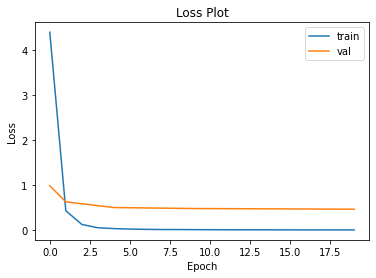

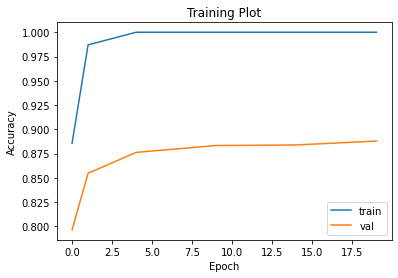

In [14]:
plot_losses(train_losses, test_losses, test_interval, num_epochs)
plot_accuracy(train_accuracy_list, test_accuracy_list, test_interval, num_epochs)

## 2.6 Evaluating trained model

In [15]:
# TO DO: initialize your trained model as you did before so that you can load the parameters into it
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True).to(device) 
# replace last layer

load_model(model, save_dir) # Load the trained weight

test_accuracy, test_loss= test(test_loader, model, criterion)
print(f"Testing accuracy is {str(test_accuracy)} \n")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Validating ...: 100%|██████████| 58/58 [00:27<00:00,  2.09it/s]

Mean Accuracy: 0.8880
Avg loss: 0.46470391862736693
Testing accuracy is 0.8879803761242846 



## Part 3: No coding for this part

## Part 4: Stretch Goals
Include any new code needed for Part 3 here

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomNetwork, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# Define data transforms for data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Initialize network and optimizer
net = CustomNetwork(num_classes=10)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the network
running_loss = 0.0

for epoch in range(50):
    running_loss


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data

# Define data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the CIFAR-10 dataset
trainset = data.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = data.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define the model
class Network(nn.Module):
    def __init__(self, num_classes=10, dropout=0.5):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        N, c, H, W = x.shape
        features = self.features(x)
        pooled_features = self.avgpool(features)
        output = self.classifier(torch.flatten(pooled_features, 1))
        return output

# Load the model and test
model = Network()
model.load_state_dict(torch.load('model.pth'))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


AttributeError: ignored

In [ ]:
pip install datasets from torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement from (from versions: none)
ERROR: No matching distribution found for from


In [ ]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers

# define the text to be tokenized
text = "I am learning about word tokenizers. They are not very complicated, and they are a good way to convert natural text into tokens."

# initialize a BPE tokenizer with a vocab size of 8000
tokenizer = Tokenizer(models.BPE(unk_token="<unk>", vocab_size=8000))

# set up the trainer
trainer = trainers.BpeTrainer(vocab_size=8000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>"
])

# train the tokenizer on the text
tokenizer.train_from_iterator([text], trainer=trainer)

# encode the text
encoded = tokenizer.encode(text)

# decode the encoded text
decoded = tokenizer.decode(encoded.ids)

# print the encoded and decoded text
print(encoded.tokens)
print(decoded)


text = "I love this class cs 441"

# initialize a BPE tokenizer with a vocab size of 8000
tokenizer = Tokenizer(models.BPE(unk_token="<unk>", vocab_size=8000))

# set up the trainer
trainer = trainers.BpeTrainer(vocab_size=8000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>"
])

# train the tokenizer on the text
tokenizer.train_from_iterator([text], trainer=trainer)

# encode the text
encoded = tokenizer.encode(text)

# decode the encoded text
decoded = tokenizer.decode(encoded.ids)

# print the encoded and decoded text
print(encoded.tokens)
print(decoded)


['I', ' a', 'm', ' ', 'l', 'e', 'a', 'r', 'n', 'in', 'g', ' a', 'b', 'o', 'u', 't ', 'w', 'o', 'r', 'd', ' token', 'i', 'z', 'er', 's.', ' ', 'T', 'hey are', ' ', 'n', 'o', 't ', 'ver', 'y', ' co', 'm', 'p', 'l', 'i', 'c', 'at', 'e', 'd', ',', ' a', 'n', 'd', ' t', 'hey are', ' a', ' ', 'g', 'o', 'o', 'd', ' ', 'w', 'a', 'y', ' to', ' co', 'n', 'ver', 't ', 'n', 'at', 'u', 'r', 'a', 'l', ' t', 'e', 'x', 't ', 'in', 't', 'o', ' token', 's.']
I  a m   l e a r n in g  a b o u t  w o r d  token i z er s.   T hey are   n o t  ver y  co m p l i c at e d ,  a n d  t hey are  a   g o o d   w a y  to  co n ver t  n at u r a l  t e x t  in t o  token s.
['I', ' ', 'l', 'o', 'v', 'e', ' ', 't', 'h', 'i', 's c', 'l', 'a', 's', 's c', 's ', '4', '4', '1']
I   l o v e   t h i s c l a s s c s  4 4 1


In [ ]:
import sentencepiece as spm
import requests

# Download WikiText-2 dataset
url = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip'
r = requests.get(url)
open('wikitext-2-v1.zip', 'wb').write(r.content)

# Extract WikiText-2 dataset
import zipfile
with zipfile.ZipFile('wikitext-2-v1.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Train tokenizer
spm.SentencePieceTrainer.train(input='wikitext-2/wiki.train.tokens', model_prefix='spm', vocab_size=8000)

# Load tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.load('spm.model')

# Encode sentence
text = 'I am learning about word tokenizers. They are not very complicated, and they are a good way to convert natural text into tokens.'
tokens = tokenizer.encode(text)
print(tokens)

# Encode additional sentence
text2 = 'The quick brown fox jumps over the lazy dog.'
tokens2 = tokenizer.encode(text2)
print(tokens2)


[68, 13, 26, 1163, 14, 3, 131, 870, 12, 4735, 829, 246, 42, 21, 15, 57, 59, 3, 420, 5186, 7, 7998, 10, 5, 15, 57, 13, 742, 484, 12, 2419, 1513, 1948, 103, 12, 4735, 4, 42]
[21, 1189, 2183, 2760, 2079, 4, 100, 5, 2211, 2465, 3584, 42]
